In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import json
from matplotlib import colormaps
import re
import io
from datetime import datetime


#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# This code is used to plot the data from the FE tester for the CV
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

%config InlineBackend.figure_format = 'retina' # For high resolution figures in Jupyter Notebook
#%matplotlib widget

## Operator window

#### Parameters to Specify

- **Input file path**  
- **Output file path**  
- **File name**  
- **Number of points to remove** (in case of breakdown)

⚠️ **Important:** Pay attention to the **output path**. The program will automatically create **4 subfolders** in the output path to store the plots and the CSV file.

In [49]:
# Set the path to the data file
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

file_path = r'E:\Nextcloud\00 - ViFOX\05 - Data\02 - FE tester\NASA_SL_ALE_10\DHM'
output_path = r'E:\Nextcloud\00 - ViFOX\05 - Data\02 - FE tester\NASA_SL_ALE_10\DHM'
file_name = 'NASA_SL_ALE_10_ID_60.dat'
full_path = os.path.join(file_path, file_name)

# If we have a breakdown during the measurement, we can remove the last n points
point_removal = 3

# Extract the last folder name from the file path
last_folder = os.path.basename(os.path.dirname(file_path))
print(last_folder)

# Séparer nom et extension
base_name = os.path.splitext(file_name)[0]
print(base_name)  # ➜ NASA_SL_ALE_10_ID_095

NASA_SL_ALE_10
NASA_SL_ALE_10_ID_60


## DHM analysis

Data analysis

In [50]:
# Read all lines once we know the indices so we can slice them.
with open(full_path, 'r', encoding='utf-8', errors='ignore') as f:
    lines = f.readlines()

header_start_index = None
header_end_index = None

for i, str in enumerate(lines):
    if f"DynamicHysteresisResult" in str:
        header_start_index = i
    if "TfaVersion" in str:
        header_end_index = i
        break

header_DHM = lines[header_start_index:header_end_index]

lines = lines[header_end_index:]
index_table = []

Number_of_dataframe = 0
for i, str in enumerate(lines):
    if "Table " in str:
        Number_of_dataframe += 1
        index_table.append(i+1)

del str, i

#DHM is metadate + data of every DHM loop
DHM = []
for i, index in enumerate(index_table):  

    if i < Number_of_dataframe - 1:
        DHM.append(lines[index:index_table[i+1]])
    if i == Number_of_dataframe - 1:
        DHM.append(lines[index:])


# --- Initialize variables to store metadata ---

SampleName = []
Area_mm2 = []
Hysteresis_Amplitude_V = []
Hysteresis_Frequence_Hz = []
Measurement_date = []


#DHM_dataframe is only the data without metadata
DHM_dataframe=[]
header_index = None

for i, loop in enumerate(DHM):
    header_index = None
    for idx, line in enumerate(loop):
        if line.count('\t') > 5 and header_index is None:
            header_index = idx
            break
    if header_index is not None:
        data_block = loop[header_index:]
        df = pd.read_csv(io.StringIO(''.join(data_block)), sep='\t', engine='python')
        DHM_dataframe.append(df)

    # --- Parse: première occurrence uniquement ---
    for metadata in loop:
        if "SampleName" in metadata:
            SampleName.append(metadata)
        if "Area [mm2]" in metadata:
            Area_mm2.append(metadata)
        if "Hysteresis Amplitude [V]" in metadata:
            Hysteresis_Amplitude_V.append(metadata)
        if "Hysteresis Frequency [Hz]" in metadata:
            Hysteresis_Frequence_Hz.append(metadata)
        if "Timestamp:" in metadata:
            # ex: "... Timestamp: 03/15/2025 14:22:11"
            Measurement_date.append(metadata.split("Timestamp:")[-1].strip())


print(len(DHM_dataframe), "P-V loops loaded.")



6 P-V loops loaded.


Plot

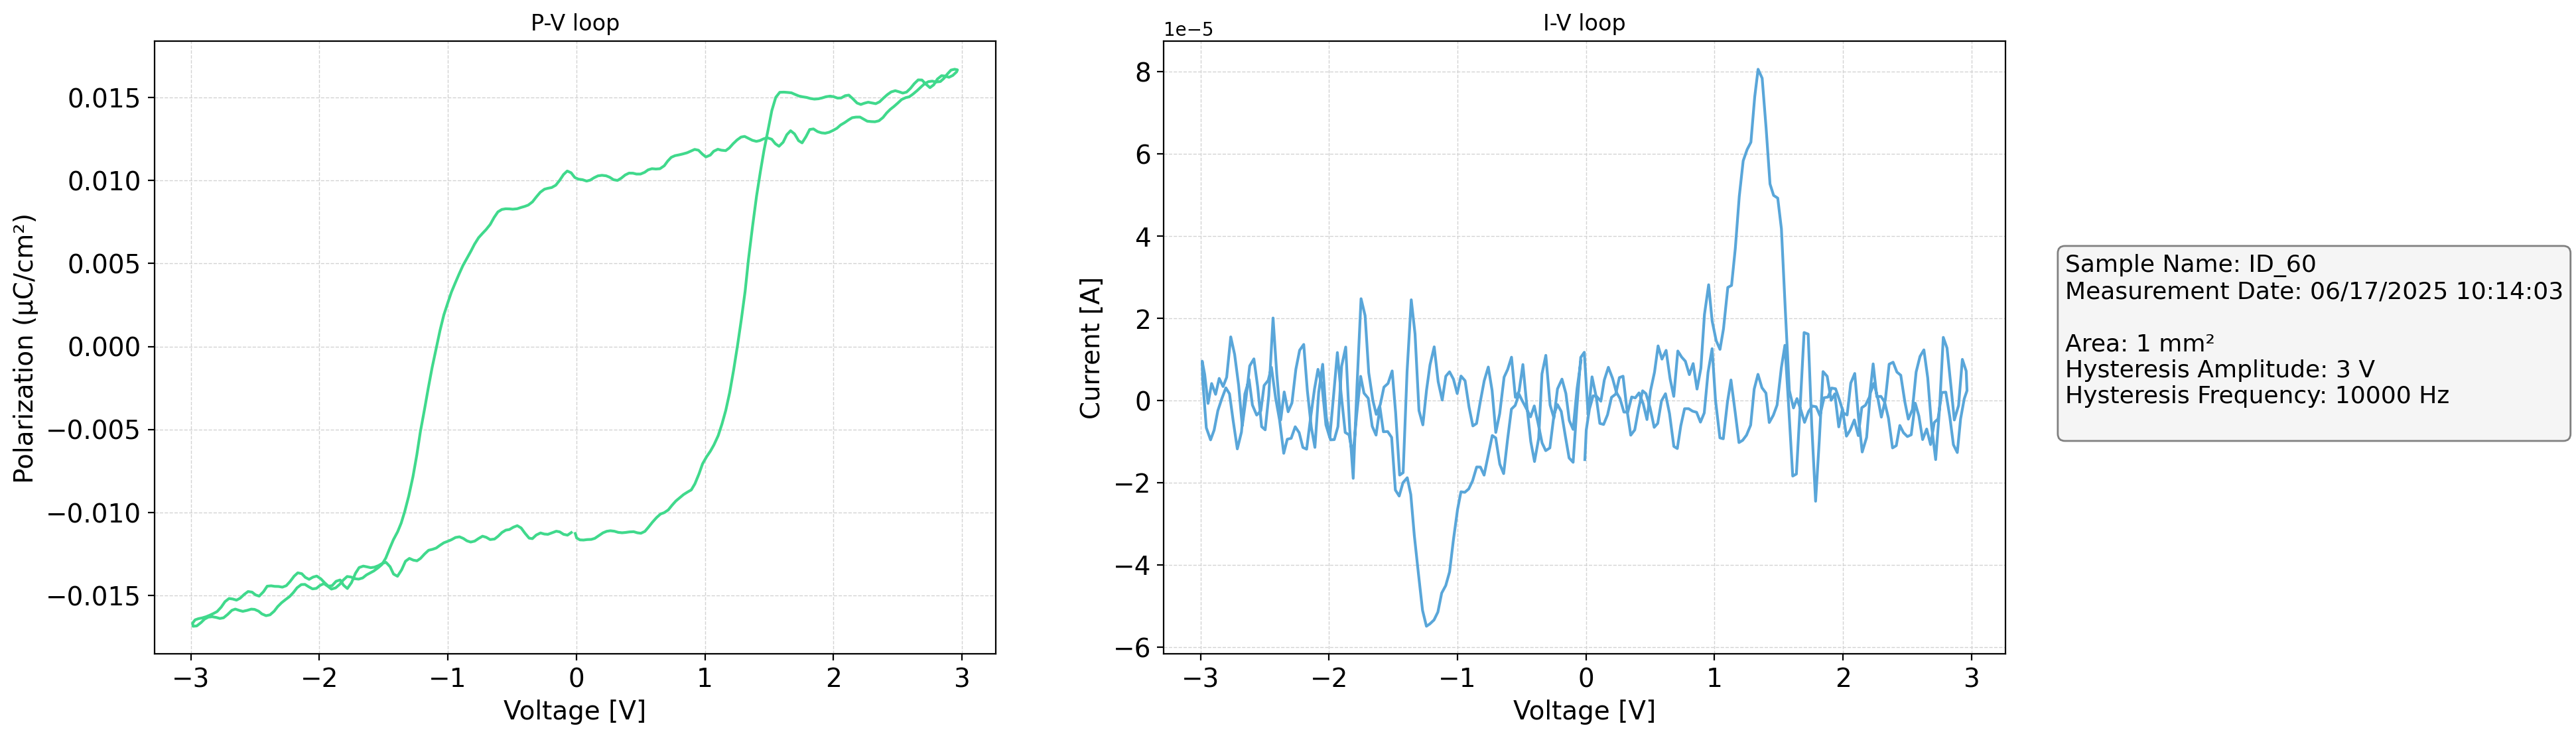

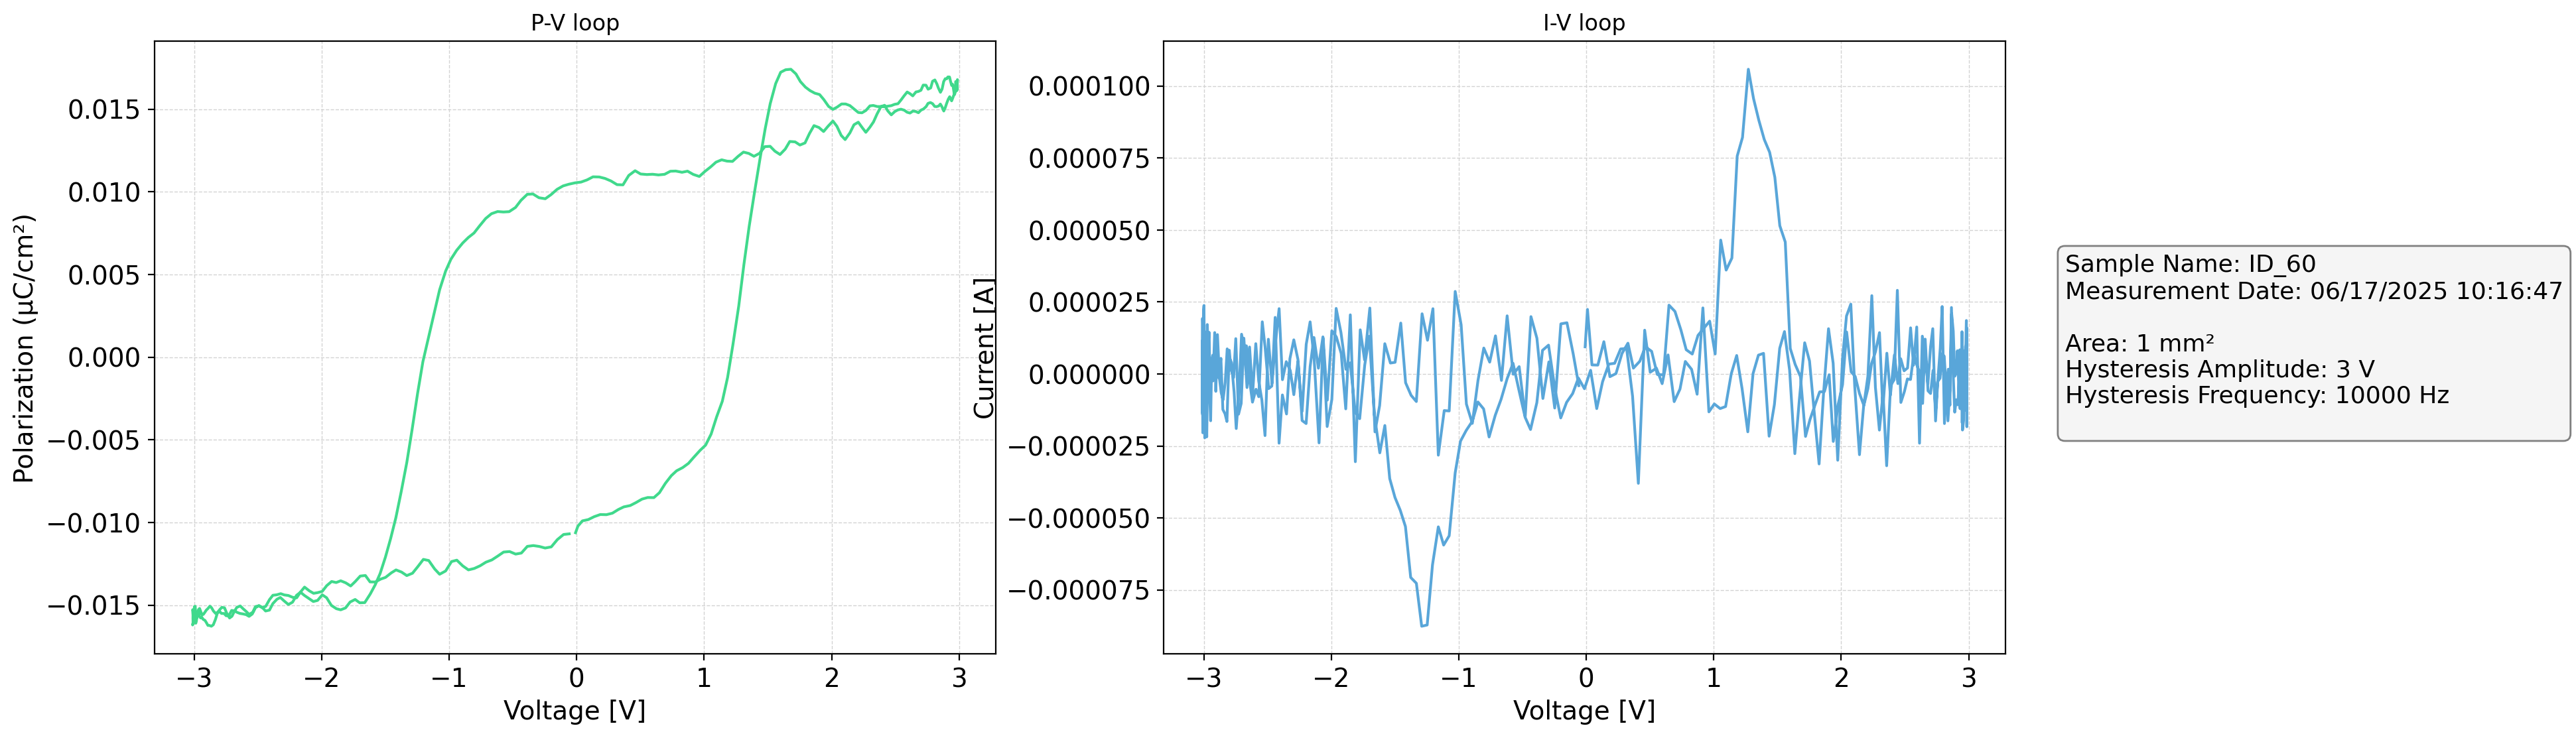

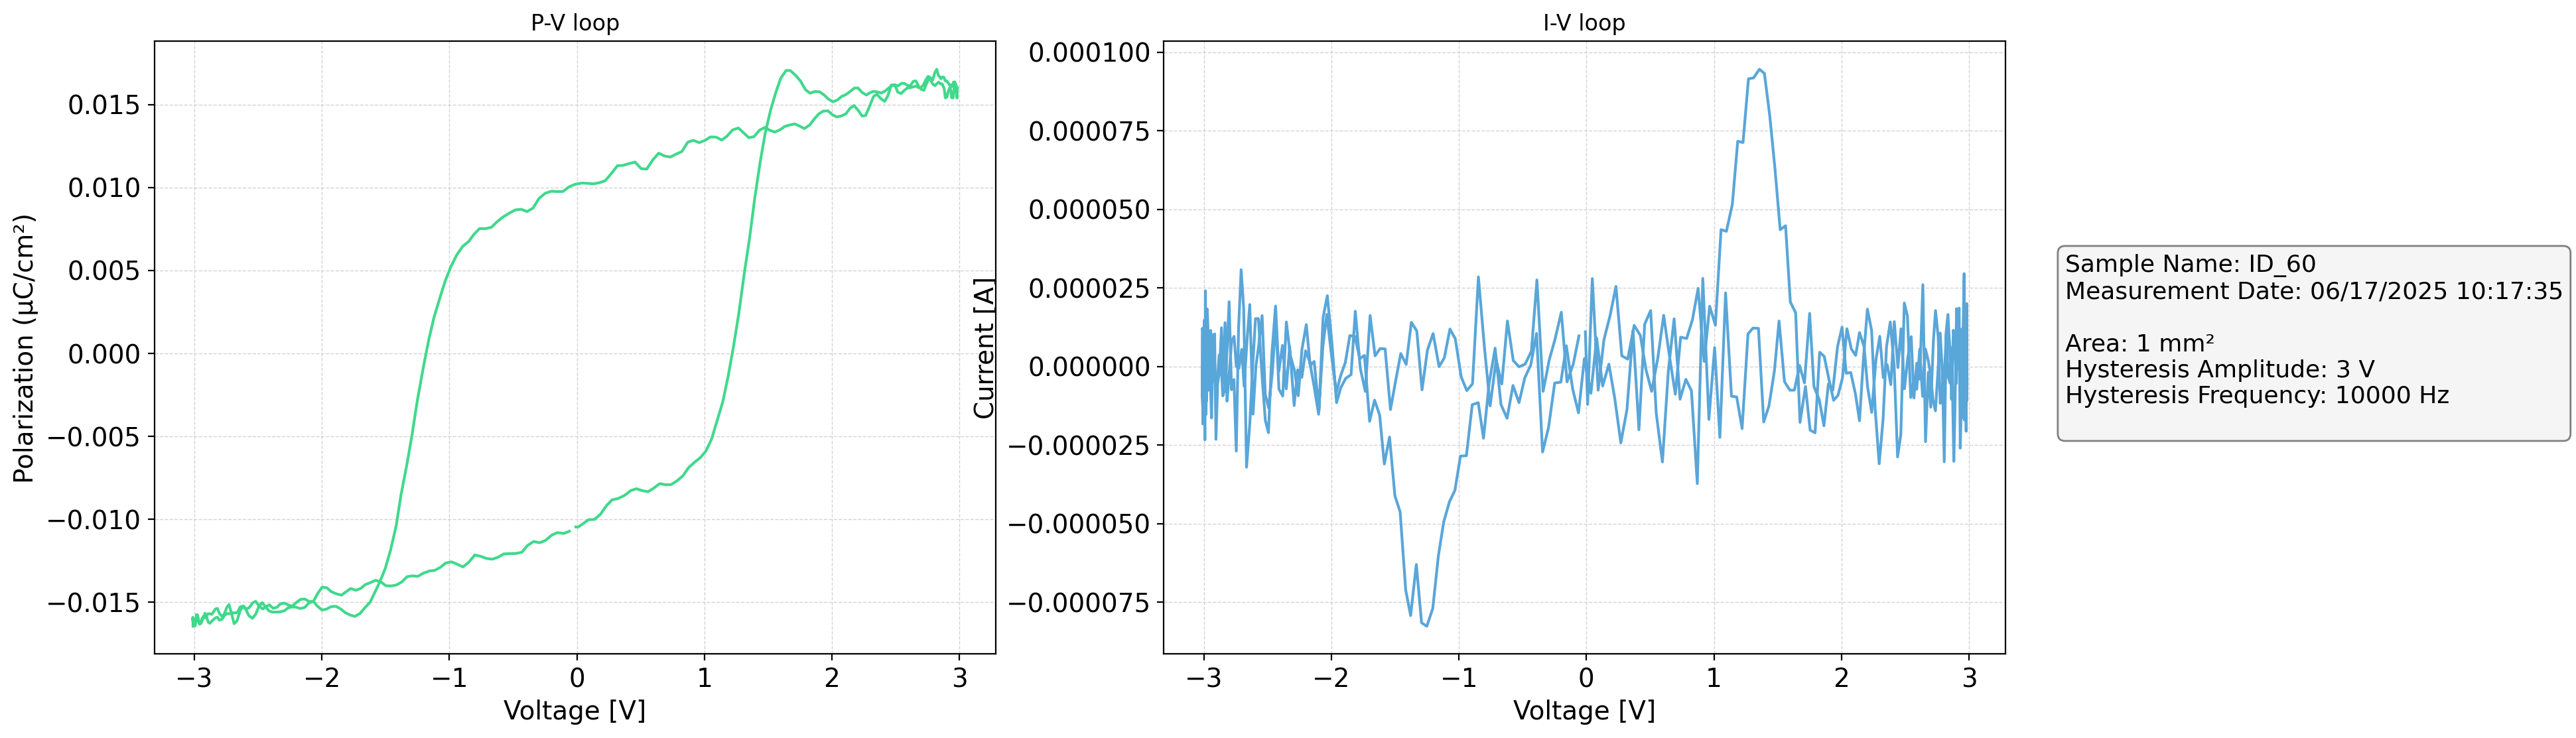

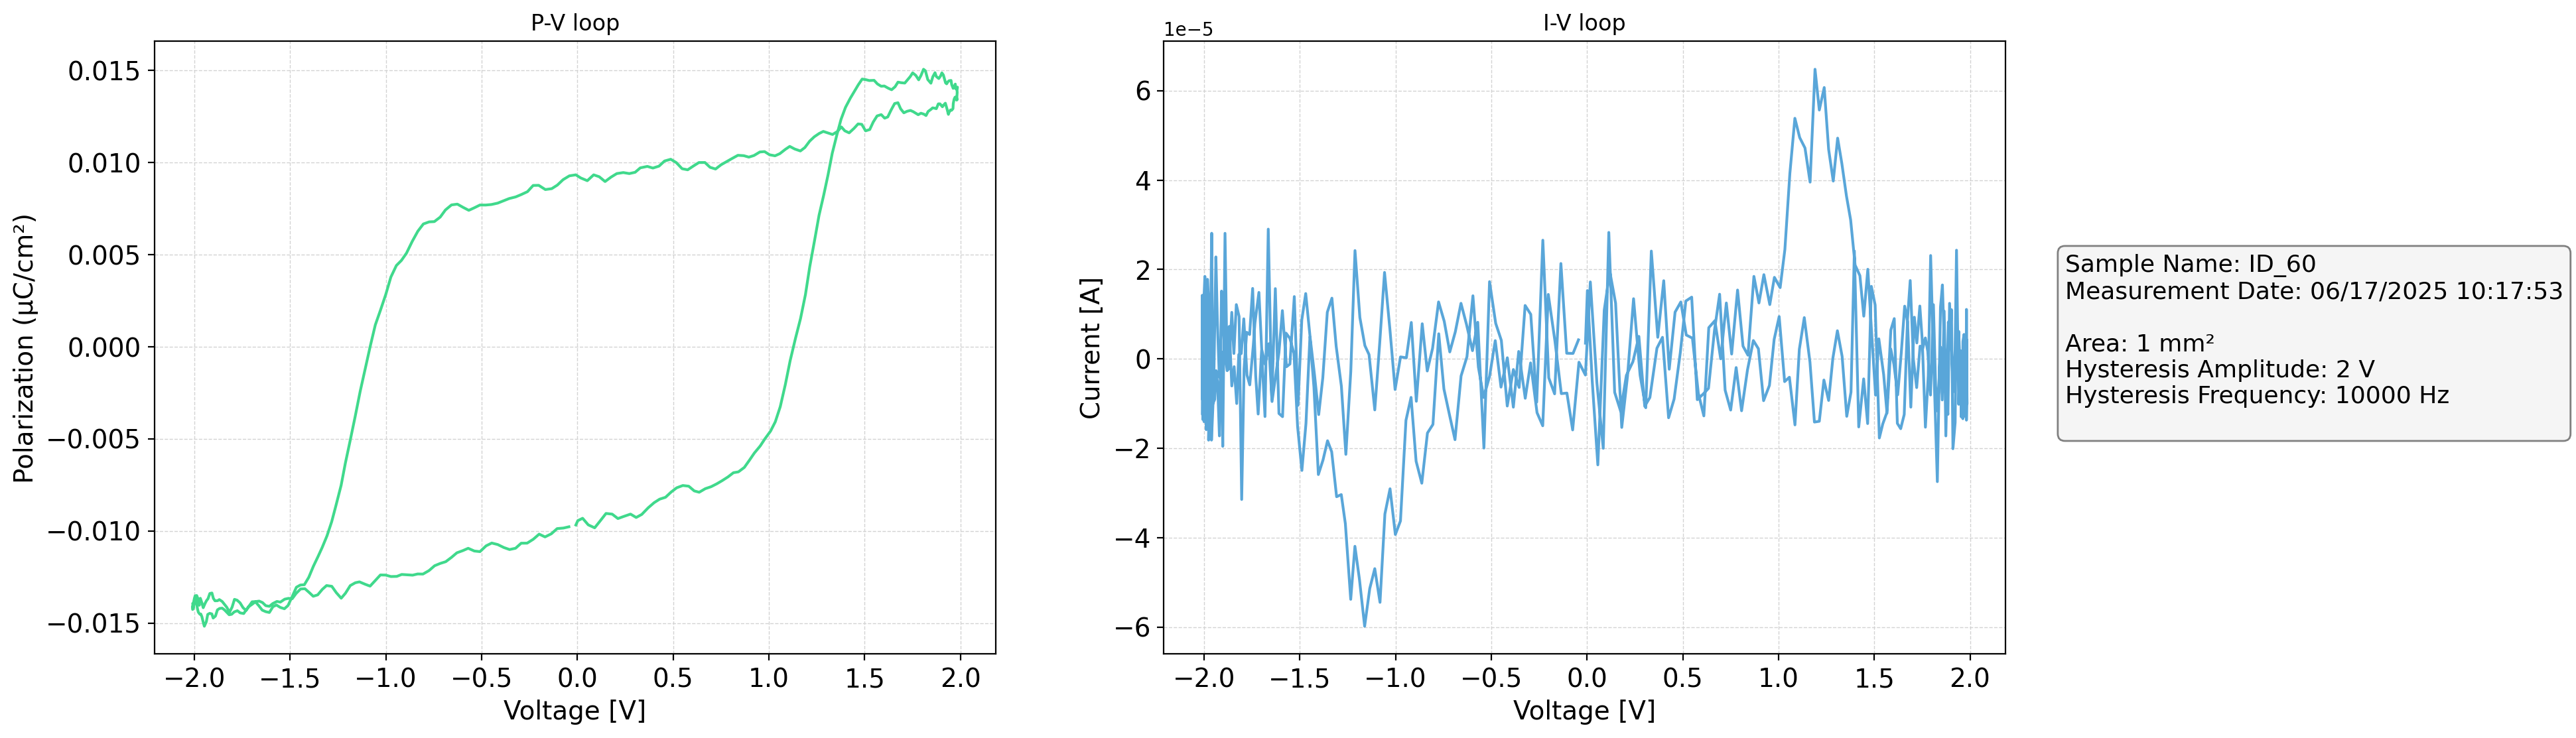

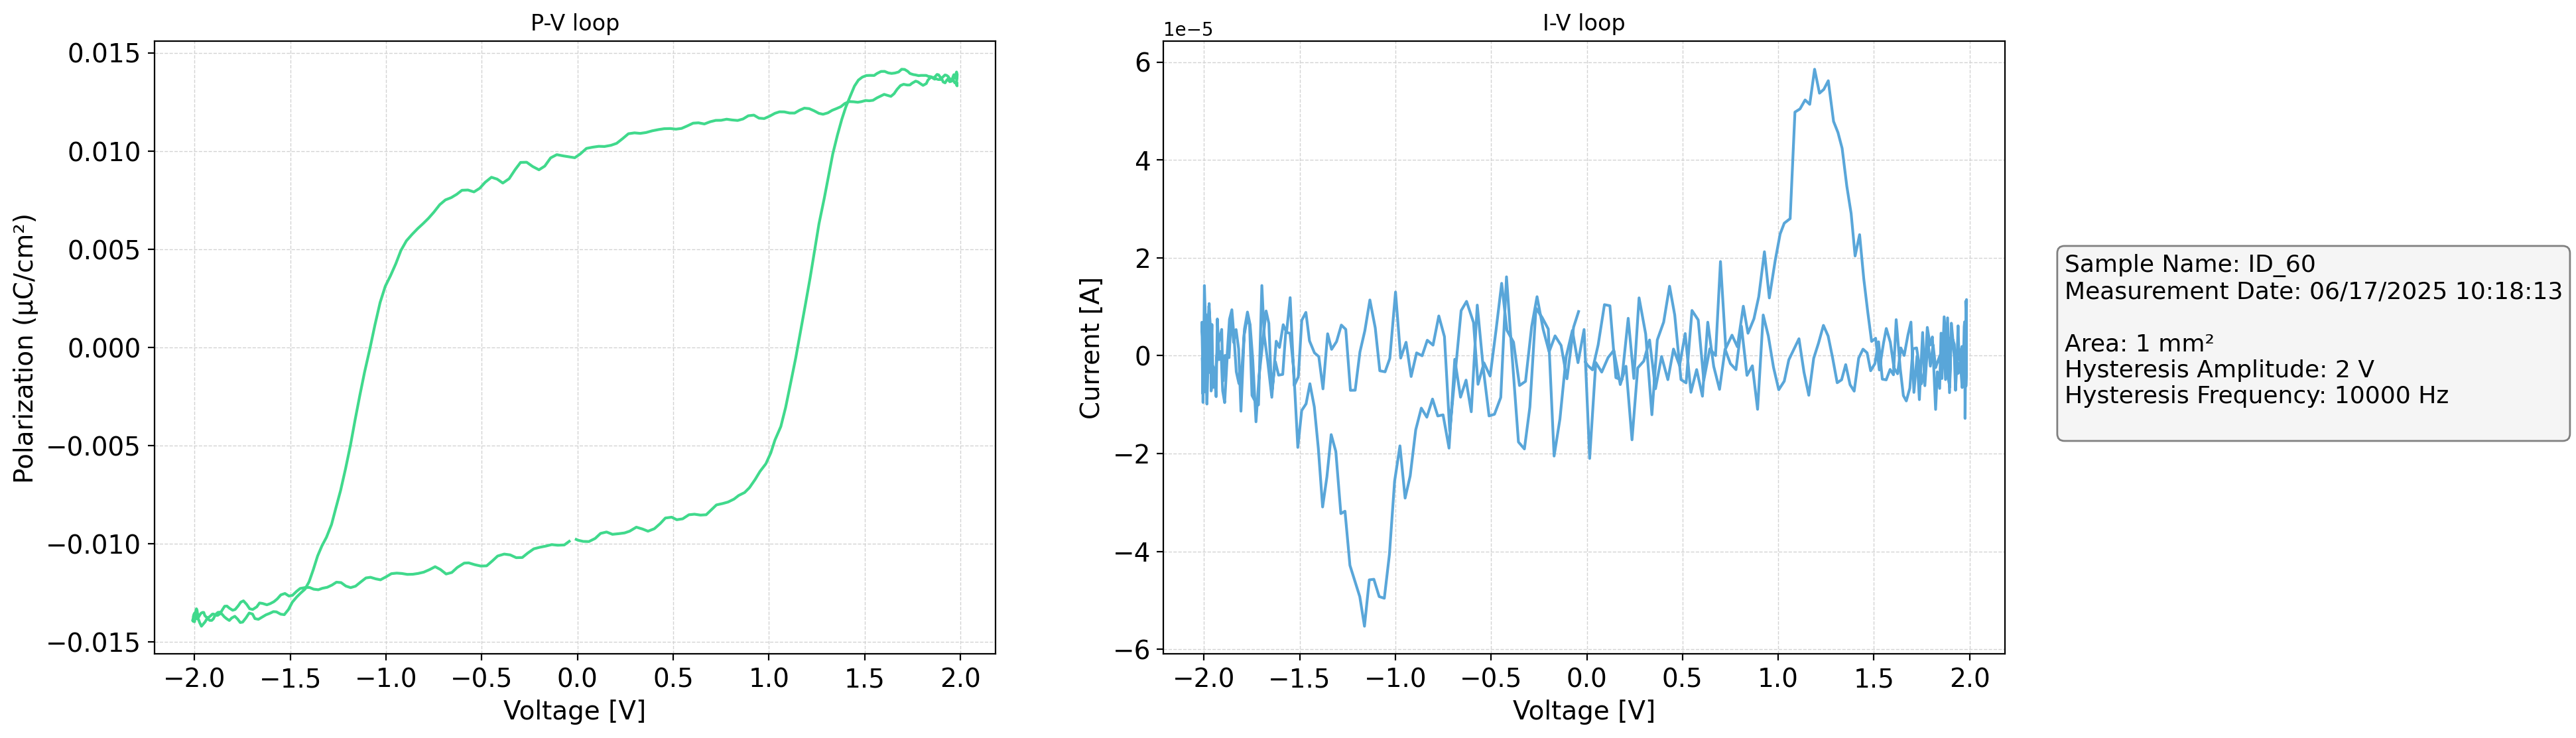

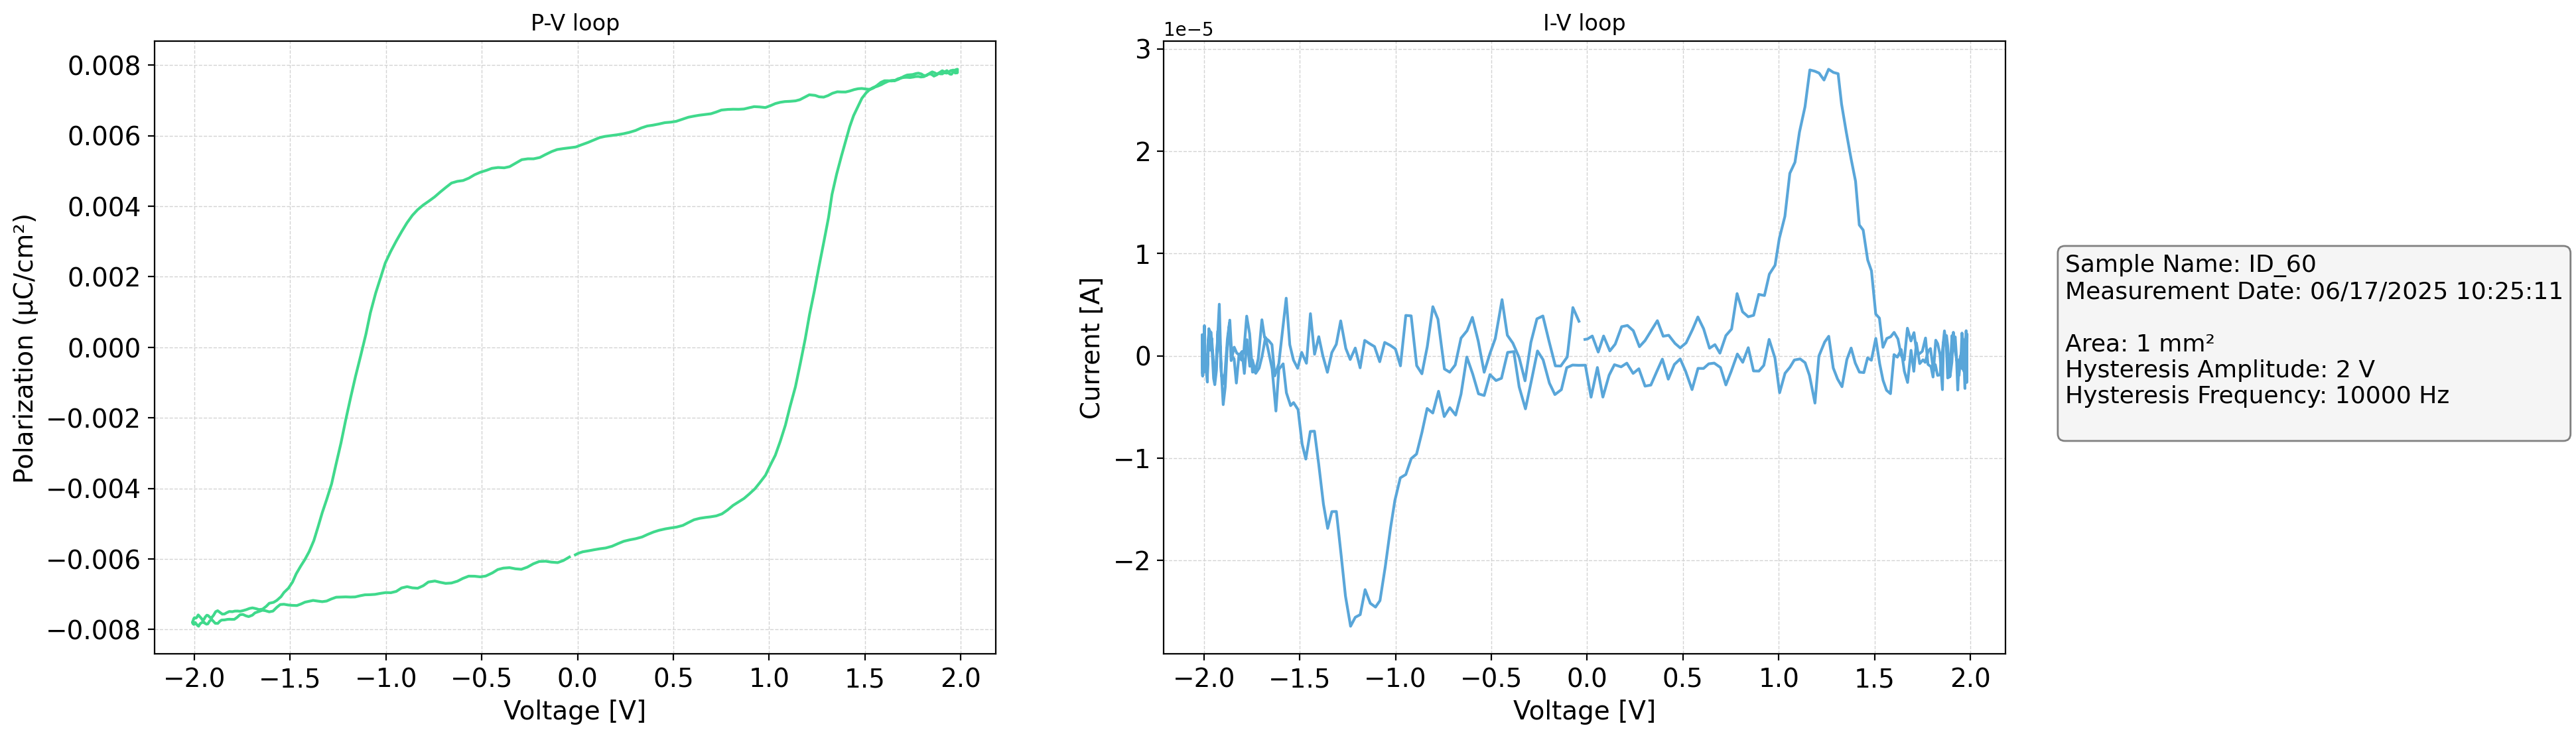

In [51]:
# Création du colormap (dégradé de bleu clair à bleu foncé)
cmap = plt.cm.Blues
colors = [cmap(i / (len(DHM_dataframe)-1)) for i in range(len(DHM_dataframe))]
label_size = 14



for i in range(len(DHM_dataframe)):
    # Create the figure
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    df = DHM_dataframe[i]

    axs[0].plot(df['V+ [V]'], df['P1 [uC/cm2]'], color=(0.25, 0.85, 0.55))
    axs[0].set_xlabel("Voltage [V]", fontsize = label_size)
    axs[0].set_ylabel("Polarization (μC/cm²)", fontsize = label_size)
    axs[0].tick_params(axis='both', labelsize= label_size)
    axs[0].set_title(f'P-V loop')
    axs[0].grid(True, color='lightgray', linestyle='--', linewidth=0.5)

    axs[1].plot(df['V+ [V]'], df['I1 [A]'], color=(0.35, 0.65, 0.85))
    axs[1].set_xlabel("Voltage [V]", fontsize = label_size)
    axs[1].set_ylabel("Current [A]", fontsize = label_size)
    axs[1].tick_params(axis='both', labelsize= label_size)
    axs[1].set_title(f'I-V loop')
    axs[1].grid(True, color='lightgray', linestyle='--', linewidth=0.5)
        
    info_text = f"Sample Name: {SampleName[i].split('SampleName:')[-1].strip()}\n" \
                f"Measurement Date: {Measurement_date[i]}\n"\
                f"\n"\
                f"Area: {Area_mm2[i].split('Area [mm2]:')[-1].strip()} mm²\n" \
                f"Hysteresis Amplitude: {Hysteresis_Amplitude_V[i].split('Hysteresis Amplitude [V]:')[-1].strip()} V\n" \
                f"Hysteresis Frequency: {Hysteresis_Frequence_Hz[i].split('Hysteresis Frequency [Hz]:')[-1].strip()} Hz\n" \
                

    # Add a text box with device info to the right of the plots
    fig.text(
        0.925,   # X position (shifted further to the right)
        0.5,    # Y position (0=bottom, 1=top)
        info_text,
        fontsize=13,
        va='center',
        bbox=dict(boxstyle="round", facecolor="whitesmoke", edgecolor="gray")
    )




    plt.show()
    plt.close()

